# Load tfrecords, define model and train

In [25]:
# Dependencies

 # TensorFlow and tf.keras
import tensorflow as tf
print('Tensorflow Version:', tf.__version__)
from tensorflow import keras
from keras import layers
from keras import models

#Tensorboard
%load_ext tensorboard


# Helper libraries
import os
import os.path
import glob
import librosa
import librosa.display
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as pd
import pprint
import datetime        
from scipy.io.wavfile import write


# Check if the GPU is available (otherwise computing will take a looooonnnnggggg time)
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")



Tensorflow Version: 2.9.1
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
GPU not available :(


In [48]:
# load global settings in config-dictionary
with open('./MA_CONFIG.json', 'r') as fp:
  config = json.load(fp)

# define some extra values
config['batch_size'] = 16
config['shuffle_buffer_size'] = 300
config['n_epochs'] = 4
# Filter:Kernel = 4:1 (see hifi-gan paper)
config['filter_size'] = 16
config['kernel_size'] = 4

# print config
print(json.dumps(config, indent=4))

# save config to disk
with open('./MA_CONFIG.json', 'w+') as fp:
    json.dump(config, fp, sort_keys=True, indent=4)


{
    "batch_size": 16,
    "filter_size": 12,
    "fps_noisy": "/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Data/allFiles/noisySpeech",
    "fps_produced": "/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Data/allFiles/producedSpeech",
    "fps_voicefixer": "/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Data/allFiles/voicefixerOutput",
    "hop_length": 64,
    "input_shape": [
        441000,
        1
    ],
    "kernel_size": 4,
    "n_epochs": 4,
    "n_fft": 512,
    "n_mels": 16,
    "offset": 6,
    "sample_length": 20,
    "shuffle_buffer_size": 300,
    "sr": 44100,
    "test_dataset_path": "../Dataset/test.tfrecord",
    "train_dataset_path": "../Dataset/train.tfrecord",
    "win_length": 512
}


# load tfrecords

### func for decoding tfrecords

In [50]:
# autotune for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

# decode tfrecords
def decode_tf_records(seralized_example):
    feature_description = {
        "voicefixer": tf.io.FixedLenFeature([], tf.string),
        "produced": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(seralized_example, feature_description)

    voicefixer, _ = tf.audio.decode_wav(example["voicefixer"], desired_channels=-1)
    produced, _ = tf.audio.decode_wav(example["produced"], desired_channels=-1)
    
    return voicefixer, produced


def slicing_audio(voicefixer, produced):
    # generate random integer between 0 and 10*44100-3*44100
    random_int = tf.random.uniform(shape=[], minval=0, maxval=7*44100, dtype=tf.int32)
    # slice audio
    voicefixer = voicefixer[random_int:random_int+3*44100]
    produced = produced[random_int:random_int+3*44100]
    return voicefixer, produced
 


In [51]:
# load train tfrecords
tfrecords_paths = glob.glob('/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/train_tfrecords/*.tfrecords')
train_dataset = tf.data.TFRecordDataset(tfrecords_paths[:8])
train_dataset = train_dataset.map(decode_tf_records, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(slicing_audio, num_parallel_calls=AUTOTUNE)

# count elements in train_dataset
print(f'Number of elements in train_dataset: {len([d for d in train_dataset])}')

# batching and shuffling
train_dataset = train_dataset.shuffle(config['shuffle_buffer_size']).batch(config['batch_size'])


Number of elements in train_dataset: 480


In [52]:
# load test tfrecords
tfrecords_paths = glob.glob('/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/test_tfrecords/*.tfrecords')
test_dataset = tf.data.TFRecordDataset(tfrecords_paths[:2])
test_dataset = test_dataset.map(decode_tf_records, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.map(slicing_audio, num_parallel_calls=AUTOTUNE)

# count elements in test_dataset
print(f'Number of elements in test_dataset: {len([d for d in test_dataset])}')

# batching and shuffling
test_dataset = test_dataset.shuffle(config['shuffle_buffer_size']).batch(config['batch_size'])


Number of elements in test_dataset: 120


In [53]:
# check if datasets are loaded correctly
for d in train_dataset:
    print(d[0].shape)
    print(d[1].shape)
    break   

for d in test_dataset:
    print(d[0].shape)
    print(d[1].shape)
    break

(16, 132300, 1)
(16, 132300, 1)
(16, 132300, 1)
(16, 132300, 1)


# look at data

In [12]:
# # look at some example data from train dataset
# wavs = train_dataset.unbatch().as_numpy_iterator()
# noisy = []
# gt = []

# # Setup Subplot
# nrows, ncols = 2, 2
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(16, 9))


# # iterate over dataset
# for i, sample in enumerate(wavs):
    
#     # get the column and row by modulo and remainder
#     j = i % ncols
#     k = int(i / ncols)
    
#     # extract noisy and produced speech file from tensors
#     wave = sample[0]
#     ground_truth = sample[1]
        
#     # plot files
#     librosa.display.waveshow(np.squeeze(wave), x_axis='time', sr=config['sr'], ax=ax[k][j], label='test_file')
#     librosa.display.waveshow(np.squeeze(ground_truth), alpha=0.3, x_axis='time', sr=config['sr'], ax=ax[k][j], label='ground_truth')
#     ax[k][j].legend()
#     ax[k][j].axis('on')
#     ax[k][j].set_title('10s speech')  

#     # save speech to arrays
#     noisy.append(np.squeeze(wave))
#     gt.append(np.squeeze(ground_truth))
    
#     if i+1 == ncols*nrows:
#         break
    
# # adjust whitespace in between subplots        
# plt.subplots_adjust(hspace=0.25, wspace=0.15)
# plt.show()


# # listen to the audio samples
# for i in range(len(gt)):
#     print(f'----------- {i+1}. speechsnippet ---------------')
#     print('')
#     print(f'Voicefixer file')
#     pd.display(pd.Audio(noisy[i].T, rate=config['sr']))
#     print(f'corresponding produced file')
#     pd.display(pd.Audio(gt[i].T, rate=config['sr']))
#     print('')

## Model architecture

In [61]:
# some values for the model
input_shape = (3*44100, 1)
output_channels = 1
filter_size = config['filter_size']
kernel_size = config['kernel_size']

# build model with 12 layers
def build_model(input_shape):

    # define model
    model = keras.Sequential(name='PostNet_Conv1D')
    model.add(keras.Input(shape=input_shape))

    # add layer 
    model.add(keras.layers.Conv1D(filters=filter_size, kernel_size=kernel_size, padding='same'))
    # add dropout layer, batch normalization and activation layer
    #model.add(keras.layers.Dropout(0.5))
    #model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('tanh'))

    # Add the remaining Conv1D layers
    for _ in range(5):
        model.add(keras.layers.Conv1D(filters=filter_size, kernel_size=kernel_size, padding='same'))
        # add dropout layer, batch normalization and activation layer
        #model.add(keras.layers.Dropout(0.5))
        #model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation('tanh'))

    # Add the final Conv1D layer without activation layer
    model.add(keras.layers.Conv1D(filters=output_channels, kernel_size=1, padding='same'))
    #model.add(keras.layers.Dropout(0.5))
    #model.add(keras.layers.BatchNormalization())

    return model

In [62]:
#--------------------------------------------
# define callbacks
log_dir = "./logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# make directory if not exist
if not os.path.exists(log_dir):
    os.makedirs(log_dir)


save_callback = keras.callbacks.ModelCheckpoint(
    filepath='./model_checkpoint',
    save_best_only=False,
    monitor='val_loss',
    verbose=0)

tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir= log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    write_steps_per_second=True,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=1)

# early_stopping_callback = keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     verbose=1)


#--------------------------------------------
# helper func
def float2pcm(sig, dtype='int16'):
    """Convert floating point signal with a range from -1 to 1 to PCM.
    Any signal values outside the interval [-1.0, 1.0) are clipped.
    No dithering is used.
    Note that there are different possibilities for scaling floating
    point numbers to PCM numbers, this function implements just one of
    them.  For an overview of alternatives see
    http://blog.bjornroche.com/2009/12/int-float-int-its-jungle-out-there.html
    Parameters
    ----------
    sig : array_like
        Input array, must have floating point type.
    dtype : data type, optional
        Desired (integer) data type.
    Returns
    -------
    numpy.ndarray
        Integer data, scaled and clipped to the range of the given
        *dtype*.
    See Also
    --------
    pcm2float, dtype
    """
    sig = np.asarray(sig)
    if sig.dtype.kind != 'f':
        raise TypeError("'sig' must be a float array")
    dtype = np.dtype(dtype)
    if dtype.kind not in 'iu':
        raise TypeError("'dtype' must be an integer type")

    i = np.iinfo(dtype)
    abs_max = 2 ** (i.bits - 1)
    offset = i.min + abs_max
    return (sig * abs_max + offset).clip(i.min, i.max).astype(dtype)


#--------------------------------------------
# set speechfile for prediction
dataset = test_dataset.unbatch().as_numpy_iterator()
speech_for_predicition = []
for i, sample in enumerate(dataset):
    speech_for_predicition.append(sample[0])
    break
# # normalize speechfile
speech_for_predicition = speech_for_predicition[0]
speech_for_predicition = librosa.util.normalize(speech_for_predicition)

# save speech file used for prediction
# save plot to disk
plt.figure(figsize=(8, 4))
x = np.arange(0, len(speech_for_predicition)/44100, 1/44100)
plt.plot(x, speech_for_predicition)
plt.title('Audiofile')
plt.xlabel('Time in s')
plt.ylabel('Amplitude')
plt.savefig(log_dir + '/_audiofile_for_prediction.png')
plt.close()

# save audiofile to disk
write(log_dir + '/_audiofile_for_prediction' + '.wav', int(44100), float2pcm(speech_for_predicition))


#--------------------------------------------
# define custom callback
class CustomCallback(keras.callbacks.Callback):
    
    # define functions to happen during training after each epoch
    def on_epoch_end(self, epoch, logs=None):
        
        # # print(logs) to check metrics
        # print('---------------------')
        # print(f'Epoch {epoch+1} Metrics:')
        # print(logs)
        # print('---------------------')
        # print('')
        

        # save predicted audio file after each epoch to disk
        # get audio file from model prediciton
        audio = self.model.predict(speech_for_predicition)

        # change shape to (len(audio), 1)
        audio = tf.squeeze(audio, axis=-1)
        audio = tf.squeeze(audio, axis=-1).numpy()
        #print(audio.shape)

        # normalize audio with numpy
        audio = librosa.util.normalize(audio).astype(np.float32)

        # save plot to disk
        plt.figure(figsize=(8, 4))
        x = np.arange(0, len(audio)/44100, 1/44100)
        plt.plot(x, audio)
        plt.title('Audiofile')
        plt.xlabel('Time in s')
        plt.ylabel('Amplitude')
        plt.savefig(log_dir + '/_audiofile_epoch' + str(epoch+1) + '.png')
        plt.close()

        # write audio file to disk (16-bit PCM WAV)
        write(log_dir + '/_audiofile_epoch' + str(epoch+1) + '.wav', 44100, float2pcm(audio))


#--------------------------------------------
# save audio files from logs to tf.summary.audio and event files for tensorboard
def save_audio_to_summaries():
    
        # get audio files from logs
        fps = glob.glob(log_dir + '/*.wav')
        path_audiosummary = log_dir + '/audiosummary/'

        # for each audio file
        for idx, fp in enumerate(fps):
            
            # write audiosummary of one audio file to disk
             writer = tf.summary.create_file_writer(path_audiosummary)
             with writer.as_default():
                
                # load audio file as tensor
                file = tf.io.read_file(fp)
                audio = tf.audio.decode_wav(file, desired_channels=1)

                # write audio file to tf.summary.audio
                name = fp.split('/')[-1]
                tf.summary.audio(name , tf.expand_dims(audio[0], 0), int(44100), step=idx)
                writer.flush()



#--------------------------------------------
# get model
model = build_model(input_shape = input_shape)

# compile model
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.04),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics = tf.keras.losses.MeanSquaredError())

model.summary()


2023-07-05 18:43:11.387843: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2023-07-05 18:43:11.387879: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2023-07-05 18:43:11.388348: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.


Model: "PostNet_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_71 (Conv1D)          (None, 132300, 12)        60        
                                                                 
 activation_61 (Activation)  (None, 132300, 12)        0         
                                                                 
 conv1d_72 (Conv1D)          (None, 132300, 12)        588       
                                                                 
 activation_62 (Activation)  (None, 132300, 12)        0         
                                                                 
 conv1d_73 (Conv1D)          (None, 132300, 12)        588       
                                                                 
 activation_63 (Activation)  (None, 132300, 12)        0         
                                                                 
 conv1d_74 (Conv1D)          (None, 132300, 12)     

In [47]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [63]:
# fit model
history = model.fit(train_dataset,
                    epochs=config['n_epochs'],
                    validation_data=test_dataset,
                    callbacks=[save_callback, tensorboard_callback, CustomCallback()])

# save model
model.save('./model.h5')

# save history
with open('./history.json', 'w+') as fp:
    json.dump(history.history, fp, sort_keys=True, indent=4)


# call def to save audio to summaries
save_audio_to_summaries()


Epoch 1/4


      1/Unknown - 3s 3s/step - loss: 0.0216 - mean_squared_error: 0.0216

2023-07-05 18:43:19.088149: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2023-07-05 18:43:19.088164: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


      2/Unknown - 4s 1s/step - loss: 0.3366 - mean_squared_error: 0.3366

2023-07-05 18:43:20.153449: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-07-05 18:43:20.156116: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2023-07-05 18:43:20.162192: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/20230705-184311/plugins/profile/2023_07_05_18_43_20

2023-07-05 18:43:20.163277: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/20230705-184311/plugins/profile/2023_07_05_18_43_20/Mariuss-MacBook-Pro.local.trace.json.gz
2023-07-05 18:43:20.165573: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/20230705-184311/plugins/profile/2023_07_05_18_43_20

2023-07-05 18:43:20.165673: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/20230705-184311/plugins/profile/2023_07_05_18_43_20/Mari

     30/Unknown - 29s 892ms/step - loss: 0.1872 - mean_squared_error: 0.1872

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


30/30 [==============================] - 34s 1s/step - loss: 0.1872 - mean_squared_error: 0.1872 - val_loss: 0.0154 - val_mean_squared_error: 0.0155
Epoch 2/4
30/30 [==============================] - ETA: 0s - loss: 0.0211 - mean_squared_error: 0.0211

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


30/30 [==============================] - 32s 1s/step - loss: 0.0211 - mean_squared_error: 0.0211 - val_loss: 0.0144 - val_mean_squared_error: 0.0141
Epoch 3/4
30/30 [==============================] - ETA: 0s - loss: 0.0213 - mean_squared_error: 0.0213

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


30/30 [==============================] - 31s 1s/step - loss: 0.0213 - mean_squared_error: 0.0213 - val_loss: 0.0149 - val_mean_squared_error: 0.0150
Epoch 4/4
30/30 [==============================] - ETA: 0s - loss: 0.0211 - mean_squared_error: 0.0211

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


30/30 [==============================] - 35s 1s/step - loss: 0.0211 - mean_squared_error: 0.0211 - val_loss: 0.0148 - val_mean_squared_error: 0.0152


In [ ]:
%tensorboard --logdir logs

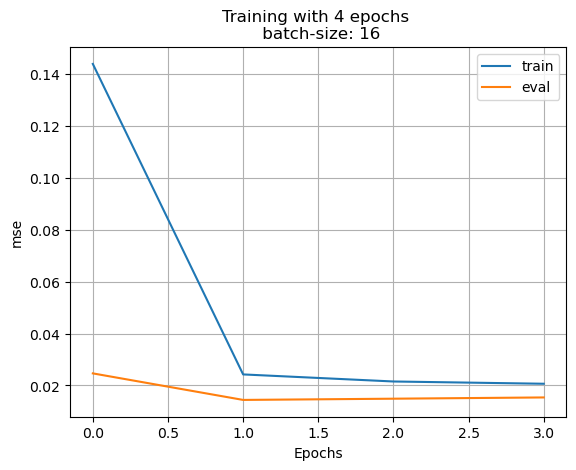

In [60]:
# plot mse
train_mse = history.history['mean_squared_error']
eval_mse = history.history['val_mean_squared_error']

fig2 = plt.figure()
plt.plot(range(config['n_epochs']), train_mse, label='train')
plt.plot(range(config['n_epochs']), eval_mse, label='eval')
plt.legend()
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('mse')
plt.title('Training with ' 
                           + str(config['n_epochs'])
                           + ' epochs \n batch-size: '
                           + str(config['batch_size']))
                     
plt.show()  

In [ ]:
# reconstructed_model = keras.models.load_model('./model.h5')
